In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
dataframe = pd.read_csv(r'C:\Users\aacjp\KC_Final.csv')
add_in = pd.read_csv(r'C:\Users\aacjp\frm_seattle.csv')

In [9]:
df = pd.concat([dataframe, add_in], axis='columns')
df

,price,sqft_lot,waterfront,lat,has_basement,sqft_living,zip_density,distance
0,221900.0,0.374187,0.0,0.5112,0,0.567220,0.661690,7.2
1,538000.0,0.479621,0.0,0.7210,1,1.235386,0.587569,8.2
2,180000.0,0.662278,0.0,0.7379,0,0.370135,0.955798,10.4
3,604000.0,0.331139,0.0,0.5208,1,0.942162,0.011237,6.4
4,510000.0,0.535120,0.0,0.6168,0,0.807567,2.937626,13.3
...,...,...,...,...,...,...,...,...
20526,360000.0,0.074904,0.0,0.6993,0,0.735463,0.472173,6.7
20527,400000.0,0.384982,0.0,0.5107,0,1.110405,0.935701,6.5
20528,402101.0,0.089407,0.0,0.5944,0,0.490309,0.798696,1.6
20529,400000.0,0.158152,0.0,0.5345,0,0.769112,2.140444,13.1


# Checking for Multicollinearity
we still have a little bit with area and lattitude, it is best to keep all values under 5, but it is worth the increased accuracy. I also seperated out y from X

In [10]:
X = df.drop(['price', 'lat'], axis='columns')
y = df['price']

pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

sqft_lot        1.213169
waterfront      1.003706
has_basement    1.703567
sqft_living     5.252351
zip_density     2.430823
distance        3.894907
dtype: float64

# Building a Linear Regression Model with Statsmodels

I wrote the formula and split the data before building the model

In [11]:
f = 'price~sqft_lot+waterfront+has_basement+sqft_living+zip_density-1'

In [12]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf

KFold(n_splits=5, random_state=None, shuffle=False)

In [13]:
indicies = []
for train_index, test_index in kf.split(df):
    indicies.append((train_index, test_index))

In [14]:
def get_score(data, formula):
    predictor = ols(formula=formula, data=data).fit()
    return predictor.rsquared

In [15]:
scores = []
 
for i in range(len(indicies)):
    X_train = X.loc[indicies[i][0]]
    X_test = X.loc[indicies[i][1]]
    data = df.loc[indicies[i][0]]
    scores.append(get_score(data, f))

In [16]:
for i in range(len(scores)):
    if scores[i] == max(scores):
        print(i)

1


In [17]:
data = df.loc[indicies[1][0]]
predictor = ols(formula=f, data=data).fit()
predictor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.898
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                          2.895e+04
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                        0.00
Time:                        07:30:46   Log-Likelihood:                     -2.2091e+05
No. Observations:               16425   AIC:                                  4.418e+05
Df Residuals:                   16420   BIC:                                  4.419e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
sqft_lot      -535.7399    514.004     -1.042      0.297   -1543.243     471.763
waterfront    2.423e+05   2.45e+04      9.878      0.000    1.94e+05     2.9e+05
has_basement  3.986e+04   2734.198     14.577      0.000    3.45e+04    4.52e+04
sqft_living   4.325e+05   2229.001    194.018      0.000    4.28e+05    4.37e+05
zip_density   3.895e+04   1570.527     24.801      0.000    3.59e+04     4.2e+04
==============================================================================
Omnibus:                      437.347   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              507.990
Skew:                           0.361   Prob(JB):                    4.91e-111
Kurtosis:                       3.469   Cond. No.                         52.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Testing for normality
perfect normality would result in the blue line being perfectly diagonal.

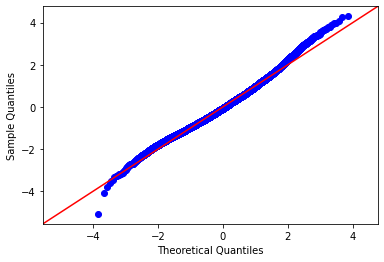

In [19]:
fig = sm.graphics.qqplot(predictor.resid, dist=stats.norm, line='45', fit=True)

In [20]:
x_cols = list(X_train.columns)

# Checking for Homoscedasticity

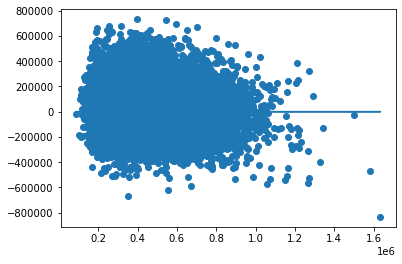

In [21]:
plt.scatter(predictor.predict(X_train[x_cols]), predictor.resid)
plt.plot(predictor.predict(X_train[x_cols]), [0 for i in range(len(X_train))]);

In [22]:
results = pd.DataFrame(list(predictor.predict(X.loc[test_index])))
results.columns = ['Predicted Price']
results['Actual Price'] = list(y[test_index])

In [23]:
te = []
pe = []
for i in range(len(results)):
    if results['Actual Price'][i] > results['Predicted Price'][i]:
        te.append(round(results['Actual Price'][i] - results['Predicted Price'][i], 2))
        pe.append(round(((results['Actual Price'][i] / results['Predicted Price'][i])-1)*100, 2))
    else:
        te.append(round(results['Predicted Price'][i] - results['Actual Price'][i], 2))
        pe.append(round(((results['Predicted Price'][i] / results['Actual Price'][i])-1)*100, 2))

# Putting test results into a table

In [25]:
results['$ Error'] = te
results['% Error'] = pe
results

,Predicted Price,Actual Price,$ Error,% Error
0,488621.415305,506500.0,17878.58,3.66
1,418567.422489,500000.0,81432.58,19.46
2,538103.385324,280000.0,258103.39,92.18
3,392754.318194,308000.0,84754.32,27.52
4,541130.619321,613500.0,72369.38,13.37
...,...,...,...,...
4101,336414.638462,360000.0,23585.36,7.01
4102,516453.343105,400000.0,116453.34,29.11
4103,243104.353753,402101.0,158996.65,65.40
4104,415903.271681,400000.0,15903.27,3.98
